In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv(path)
df.head()

,V1,V2,V3,V4,V5,VP
0,2.0,-29.0,-28.0,-32.0,-27.0,0.0
1,9.0,17.0,18.0,21.0,27.0,-2.0
2,-13.0,-6.0,4.0,8.0,-1.0,-8.0
3,4.0,-9.0,-22.0,-21.0,-10.0,-10.0
4,12.0,15.0,22.0,14.0,6.0,6.0


In [3]:
def create_feature_target_dataframe(df, column):
    values = df[column].values
    
    # Initialize lists to store the feature rows and targets
    features = []
    targets = []

    # Loop through the values, taking 5 values as features and the 6th as the target
    for i in range(len(values) - 5):
        feature_row = values[i:i+5]
        target = values[i+5]
        
        # Append the feature row and target to the respective lists
        features.append(feature_row)
        targets.append(target)
    
    # Create a new DataFrame from the feature rows and targets
    new_df = pd.DataFrame(features, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
    new_df['target'] = targets
    
    return new_df

In [4]:
v1_df = create_feature_target_dataframe(df, column='V2')
v1_df.head()

,x1,x2,x3,x4,x5,target
0,-29.0,17.0,-6.0,-9.0,15.0,-2.0
1,17.0,-6.0,-9.0,15.0,-2.0,-5.0
2,-6.0,-9.0,15.0,-2.0,-5.0,-4.0
3,-9.0,15.0,-2.0,-5.0,-4.0,21.0
4,15.0,-2.0,-5.0,-4.0,21.0,-28.0


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x = v1_df.drop('target',axis=1)
y = v1_df['target']

In [7]:
x_train,x_test,y_train,y_test = train_test_split(
    x,y, 
    test_size=0.2,
    shuffle=False
)

In [8]:
x_train.shape,x_test.shape

((1995, 5), (499, 5))

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout, Normalization,Bidirectional
from tensorflow.keras.layers import TimeDistributed, Conv1D,MaxPool1D,Flatten
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.optimizers import Adam

2024-06-21 12:32:21.140120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 12:32:21.140235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 12:32:21.346208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [11]:
x_train.shape

(1995, 5)

In [15]:
# Reshape the data for LSTM [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [16]:
x_train.shape, x_test.shape

((1995, 1, 5), (499, 1, 5))

In [17]:
# Define the model architecture
model = Sequential()
model.add(Bidirectional(LSTM(500, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(250, activation='tanh', return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(200, activation='tanh', return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(200, activation='tanh')))
model.add(Dropout(0.1))
model.add(Dense(100))
model.add(Dense(1))

# Define the optimizer with a specific learning rate
learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['Acc'])

# Display the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=10, 
                    validation_data=(x_test, y_test), 
                    shuffle=False)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - Acc: 0.0281 - loss: 195.0389 - val_Acc: 0.0200 - val_loss: 261.0580
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Acc: 0.0283 - loss: 192.5933 - val_Acc: 0.0200 - val_loss: 248.5576
Epoch 3/100
 90/200 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Acc: 0.0298 - loss: 170.0176

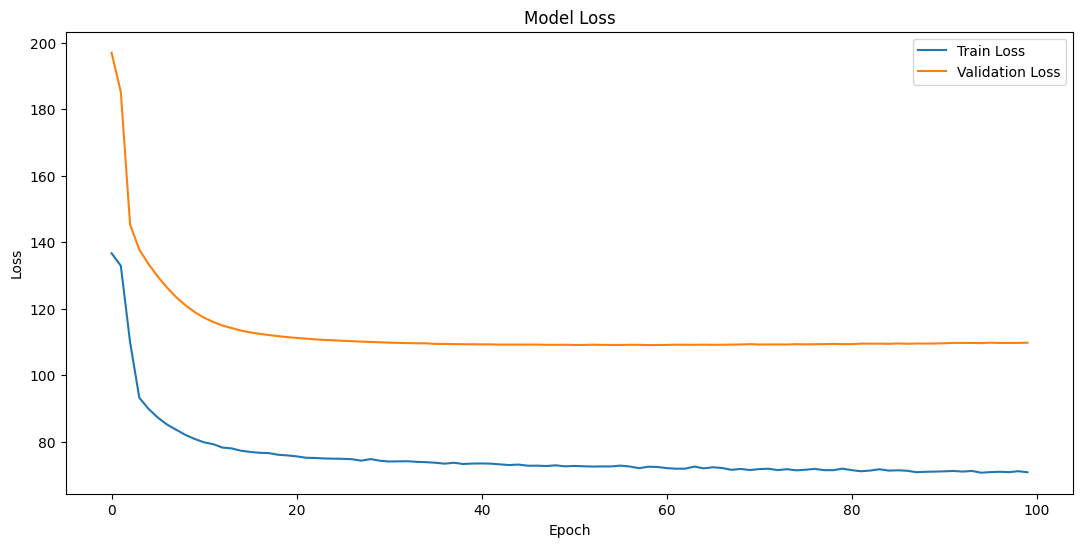

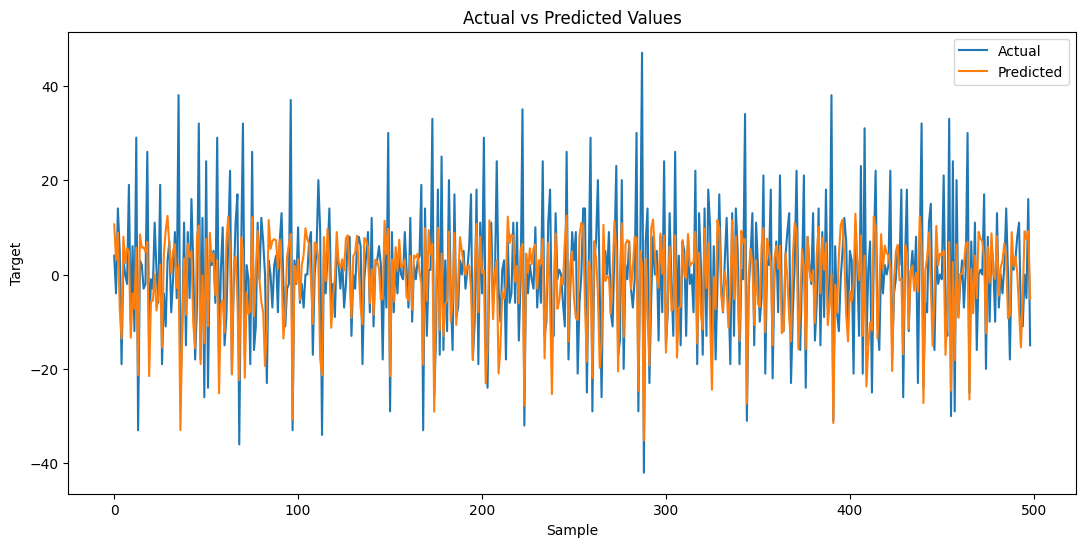

In [21]:
plt.figure(figsize=(13,6))
# Make predictions
y_pred = model.predict(x_test, verbose=0)
y_test = np.array(y_test)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot the actual vs predicted values
plt.figure(figsize=(13,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Target')
plt.legend()
plt.show()